In [89]:
import boto3
import botocore
import sagemaker
import sys


bucket = 'doyeongkim-anomaly-detection'   # <--- specify a bucket you have access to
prefix = 'sagemaker/rcf-benchmarks'
execution_role = sagemaker.get_execution_role()


# check if the bucket exists
try:
    boto3.Session().client('s3').head_bucket(Bucket=bucket)
except botocore.exceptions.ParamValidationError as e:
    print('Hey! You either forgot to specify your S3 bucket'
          ' or you gave your bucket an invalid name!')
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == '403':
        print("Hey! You don't have permission to access the bucket, {}.".format(bucket))
    elif e.response['Error']['Code'] == '404':
        print("Hey! Your bucket, {}, doesn't exist!".format(bucket))
    else:
        raise
else:
    print('Training input/output will be stored in: s3://{}/{}'.format(bucket, prefix))

Training input/output will be stored in: s3://doyeongkim-anomaly-detection/sagemaker/rcf-benchmarks


In [134]:
%%time

import pandas as pd
import urllib.request

data_filename = 'aws_data.csv'
taxi_data_ = pd.read_csv(data_filename, delimiter=',')

CPU times: user 1.88 ms, sys: 729 µs, total: 2.61 ms
Wall time: 2.22 ms


In [135]:
taxi_data_.head()

,timestamp,value
0,2000-01-01T00:00:00,8.260354
1,2000-01-02T00:00:00,12.807938
2,2000-01-03T00:00:00,12.927103
3,2000-01-04T00:00:00,10.987465
4,2000-01-05T00:00:00,10.080948


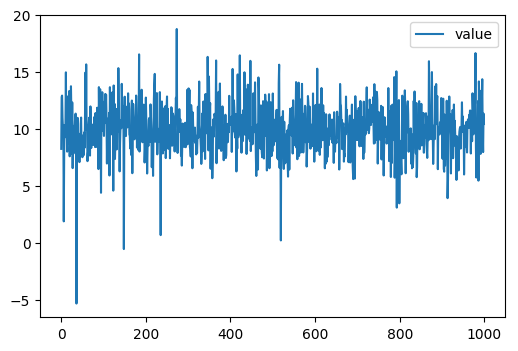

In [136]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 100

taxi_data_.plot()

In [137]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=execution_role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(taxi_data_.value.as_matrix().reshape(-1,1)))

INFO:sagemaker:Creating training-job with name: randomcutforest-2019-05-11-12-07-44-310


2019-05-11 12:07:44 Starting - Starting the training job...
2019-05-11 12:07:47 Starting - Launching requested ML instances......
2019-05-11 12:08:48 Starting - Preparing the instances for training...
2019-05-11 12:09:36 Downloading - Downloading input data
2019-05-11 12:09:36 Training - Downloading the training image......
2019-05-11 12:10:41 Uploading - Uploading generated training model
2019-05-11 12:10:41 Completed - Training job completed

Docker entrypoint called with argument(s): train
[05/11/2019 12:10:31 INFO 140112049006400] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_ftp_port': 8999, u'num_samples_per_tree': 256, u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'_log_level': u'info', u'_kvstore': u'dist_async', u'force_dense': u'true', u'epochs': 1, u'num_trees': 100, u'eval_metrics': [u'accuracy', u'precision_recall_fscore'], u'_num_kv_servers': u'auto', u'mini_batch_size': 1000}
[05/11/2019 

Billable seconds: 79


In [138]:
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2019-05-11-12-07-44-310


In [139]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2019-05-11-12-11-09-176
INFO:sagemaker:Creating endpoint with name randomcutforest-2019-05-11-12-07-44-310


---------------------------------------------------------------------------------------!

In [140]:
print('Endpoint name: {}'.format(rcf_inference.endpoint))

Endpoint name: randomcutforest-2019-05-11-12-07-44-310


In [141]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [142]:
taxi_data_numpy = taxi_data_.value.as_matrix().reshape(-1,1)
print(taxi_data_numpy[:6])
results = rcf_inference.predict(taxi_data_numpy[:6])

[[ 8.26035397]
 [12.80793766]
 [12.92710309]
 [10.98746463]
 [10.08094754]
 [10.35368879]]


In [143]:
results = rcf_inference.predict(taxi_data_numpy)
scores = [datum['score'] for datum in results['scores']]

# add scores to taxi data frame and print first few values
taxi_data_['score'] = pd.Series(scores, index=taxi_data_.index)
taxi_data_.head()

,timestamp,value,score
0,2000-01-01T00:00:00,8.260354,0.901603
1,2000-01-02T00:00:00,12.807938,1.160905
2,2000-01-03T00:00:00,12.927103,1.185031
3,2000-01-04T00:00:00,10.987465,0.800484
4,2000-01-05T00:00:00,10.080948,0.645090


In [145]:
len(taxi_data_)

1000

In [146]:
score_mean = taxi_data_['score'].mean()
score_std = taxi_data_['score'].std()
score_cutoff = score_mean + 3*score_std

anomalies = taxi_data_subset[taxi_data_subset['score'] > score_cutoff]
anomalies

,timestamp,value,score
6,2000-01-07T00:00:00,1.909988,2.650933
36,2000-02-06T00:00:00,-5.288617,3.312636
59,2000-02-29T00:00:00,15.662677,2.118073
94,2000-04-04T00:00:00,4.414981,2.143411
123,2000-05-03T00:00:00,4.601102,2.090867
135,2000-05-15T00:00:00,15.333310,2.023372
148,2000-05-28T00:00:00,-0.514109,2.950722
184,2000-07-03T00:00:00,16.539581,2.335690
235,2000-08-23T00:00:00,0.706027,2.813849
273,2000-09-30T00:00:00,18.761050,2.767864


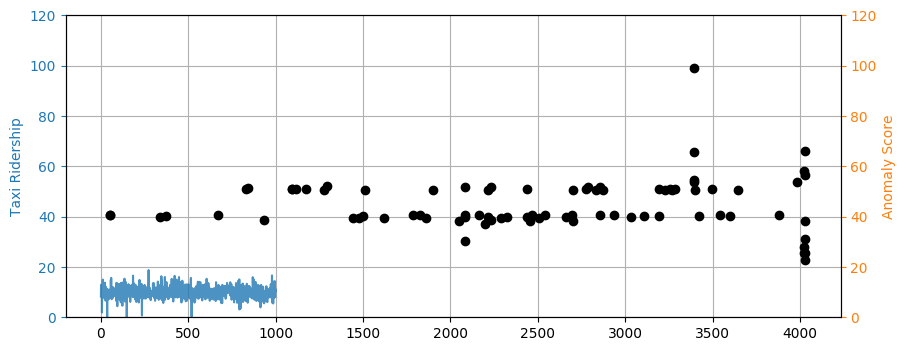

In [144]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#
# *Try this out* - change `start` and `end` to zoom in on the 
# anomaly found earlier in this notebook
#
start, end = 0, len(taxi_data_)
#start, end = 5500, 6500
taxi_data_subset = taxi_data_[start:end]

ax1.plot(taxi_data_['value'], color='C0', alpha=0.8)
# ax2.plot(taxi_data_subset['score'], color='C1')
ax2.plot(anomalies.index, anomalies.value, 'ko')

ax1.grid(which='major', axis='both')

ax1.set_ylabel('Taxi Ridership', color='C0')
ax2.set_ylabel('Anomaly Score', color='C1')

ax1.tick_params('y', colors='C0')
ax2.tick_params('y', colors='C1')

ax1.set_ylim(0, 120)
ax2.set_ylim(0, 120)

# ax2.set_ylim(min(scores), 1.4*max(scores))
fig.set_figwidth(10)

In [67]:
score_mean = taxi_data['score'].mean()
score_std = taxi_data['score'].std()
score_cutoff = score_mean + 3*score_std

anomalies = taxi_data_subset[taxi_data_subset['score'] > score_cutoff]
anomalies

,timestamp,value,score
50,2014-03-07 07:51:00,40.586,2.070541
55,2014-03-07 08:16:00,40.610,2.063434
338,2014-03-08 07:51:00,39.718,2.530946
374,2014-03-08 10:51:00,40.306,2.248894
670,2014-03-09 11:31:00,40.586,2.070541
833,2014-03-10 01:06:00,50.906,2.464551
839,2014-03-10 01:36:00,51.198,2.602393
934,2014-03-10 09:31:00,38.498,3.088043
1093,2014-03-10 22:46:00,50.992,2.493721
1095,2014-03-10 22:56:00,50.938,2.476410


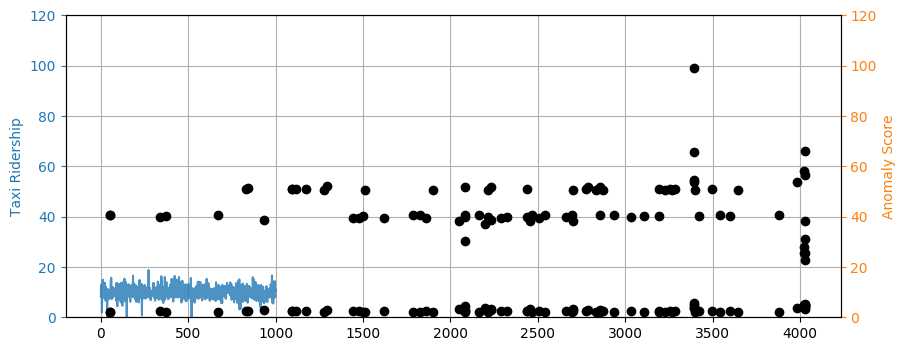

In [129]:
ax2.plot(anomalies.index, anomalies.score, 'ko')
fig

In [88]:
sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

INFO:sagemaker:Deleting endpoint with name: randomcutforest-2019-05-02-07-14-06-168
